In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import pandas as pd
from scipy import ndimage
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [18]:
def calculate_centroid_and_area(image):
    
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(img_hsv,(31, 69, 20), (82, 255, 255))
    
    area = np.sum(mask)/255
    centroid = ndimage.center_of_mass(mask)
    
    return [area,centroid]

In [19]:
# Assumes there are an equal number of top and front images
number_of_files = len([name for name in os.listdir('../Images') if name[0]!="."])
number_of_plants = int(number_of_files / 2)

results = pd.DataFrame(columns=['Plant_number', 'Area_front', 'Centroid_front', 'Area_top', 'Centroid_top'])

for x in range(number_of_plants):
    row = []
    
    row.append("Plant" + str(x+1))
    
    image_front = cv2.imread(f'../Images/Plant{x+1}_front_Color.png')
    image_top = cv2.imread(f'../Images/Plant{x+1}_top_Color.png')
    
    front_result = calculate_centroid_and_area(image_front)
    top_result = calculate_centroid_and_area(image_top)
    
    row = row + front_result + top_result
    
    results.loc[len(results)] = row
    
print(results)
    

   Plant_number  Area_front                           Centroid_front  \
0        Plant1     72055.0   (321.6569009784193, 667.9332315592256)   
1        Plant2     68354.0   (335.5661702314422, 706.0572607309009)   
2        Plant3     40422.0  (401.83724209588837, 649.1364850823809)   
3        Plant4     62747.0  (331.01727572632956, 692.3932937032846)   
4        Plant5     56655.0   (351.8390433324508, 751.1261671520607)   
5        Plant6     36733.0   (376.9781667710233, 719.6792802112542)   
6        Plant7     58318.0  (398.34088960526765, 653.4697691964745)   
7        Plant8     69904.0  (419.84069581139846, 630.2788395513847)   
8        Plant9     62220.0  (437.33539054966246, 648.5444069431051)   
9       Plant10     41865.0    (406.4778693419324, 614.602651379434)   
10      Plant11     58057.0    (392.908744854195, 675.5261208812029)   
11      Plant12     96526.0    (350.6438472535897, 666.881534508837)   
12      Plant13     90898.0    (352.8019208343418, 696.223525270

In [20]:
PlantData = pd.read_csv("../PlantData.csv")

In [21]:
Data = results.join(PlantData.set_index('Plant_number'), on='Plant_number')

In [26]:
# Separate Target Variable and Predictor Variables
TargetVariable=['LAI']
Predictors=['Area_top','Area_front']
 
X=Data[Predictors].values
y=Data[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
i=0
k=5
cv = KFold(n_splits=k, random_state=42, shuffle=True)
cv.get_n_splits(X)
mae=np.zeros(k)
for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train)
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train, y_train)
    close_predictions = regr.predict(X_test)
    close_predictions = TargetVarScalerFit.inverse_transform(close_predictions.reshape(-1, 1))
    close_predictions = close_predictions.flatten()
    y_test = TargetVarScalerFit.inverse_transform(y_test)
    y_test = y_test.flatten()
    print(close_predictions)

    mae[i] = sum(abs(close_predictions - y_test)) / y_test.shape[0]
    i+=1
print(mae)
mae_average = np.average(mae)
maepercent_average = mae_average/np.average(Data['LAI'])
print(maepercent_average)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 20 21 22 23 24 27 28
 29 31 33 34 35 36 37 38 40 41 42 43 44 46 47 49] TEST: [13 17 19 25 26 30 32 39 45 48]
[[-0.22898968 -0.49009433]
 [ 0.02087746 -0.68889345]
 [-1.90664391 -2.18926005]
 [-0.63530377 -0.99007329]
 [-1.29346144 -1.31730491]
 [-1.88933899 -2.38741458]
 [-1.87545992 -1.22797691]
 [-1.47050739 -0.60563524]
 [-1.85705698 -1.01838109]
 [-1.76306583 -2.11174935]
 [-1.12840595 -1.24199651]
 [ 0.10226325  0.82436475]
 [ 1.60559464  0.52205689]
 [-0.43708785  0.29371454]
 [ 0.06791695 -0.4071047 ]
 [ 0.13230528  0.13380507]
 [-0.82464763 -0.01315909]
 [ 0.6708658   0.97981588]
 [-0.28538437 -0.57335254]
 [ 0.65865574  0.73444589]
 [-0.7669353   0.1163477 ]
 [-0.08167831 -0.49310237]
 [ 0.52254425 -0.32894942]
 [ 1.50866077  1.6766065 ]
 [-0.36233414  0.33953341]
 [ 0.51345258  0.44664107]
 [ 0.20411628  0.30708957]
 [ 0.37813168 -0.4146248 ]
 [-0.06371458  1.1879614 ]
 [ 1.07441286  0.07267743]
 [ 0.7963923  -0.07031

C:\Users\Jeroen.cro\AppData\Local\Temp\ipykernel_7796\2656644949.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\Jeroen.cro\AppData\Local\Temp\ipykernel_7796\2656644949.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\Jeroen.cro\AppData\Local\Temp\ipykernel_7796\2656644949.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)
C:\Users\Jeroen.cro\AppData\Local\Temp\ipykernel_7796\2656644949.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg

[1178.26491833  669.7317     1221.8951454   814.93661667  936.87084167
  936.8417     1194.27666556 1251.0936787  1167.69690624  822.42176667]
TRAIN: [ 0  1  2  3  4  5  6  8  9 11 12 13 15 16 17 19 21 23 24 25 26 27 29 30
 31 32 33 34 35 36 37 39 40 41 43 44 45 46 47 48] TEST: [ 7 10 14 18 20 22 28 38 42 49]
[[-0.22898968 -0.49009433]
 [ 0.02087746 -0.68889345]
 [-1.90664391 -2.18926005]
 [-0.63530377 -0.99007329]
 [-1.29346144 -1.31730491]
 [-1.88933899 -2.38741458]
 [-1.87545992 -1.22797691]
 [-1.85705698 -1.01838109]
 [-1.76306583 -2.11174935]
 [ 0.10226325  0.82436475]
 [ 1.60559464  0.52205689]
 [-0.04553125 -0.12520853]
 [ 0.06791695 -0.4071047 ]
 [ 0.13230528  0.13380507]
 [ 1.58987088  1.0484099 ]
 [ 0.08355286  0.28904134]
 [-0.28538437 -0.57335254]
 [-0.7669353   0.1163477 ]
 [-0.08167831 -0.49310237]
 [ 0.46641309 -0.30832287]
 [ 0.58148637  0.65817063]
 [ 0.52254425 -0.32894942]
 [-0.36233414  0.33953341]
 [-0.9952811   0.13299935]
 [ 0.51345258  0.44664107]
 [ 0.83420837 

C:\Users\Jeroen.cro\AppData\Local\Temp\ipykernel_7796\2656644949.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


65.23661636516245
   Actuals  Predictions  Plant Numbers
2   964.64   985.919577              1
0  1199.86  1111.471557              2
3  1216.18  1310.612367              3
9  1220.36  1212.168142              4
8  1321.61  1266.447998              5
7  1335.69  1298.796647              6
5  1343.02  1326.226606              7
6  1358.58  1310.361063              8
4  1363.92  1324.037310              9
1  1606.91  1363.786458             10


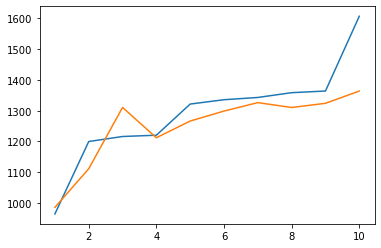

In [22]:


print(mae)
RF_results = pd.DataFrame(columns = ['Actuals'])
RF_results['Predictions'] = close_predictions
RF_results['Actuals'] = y_rem.to_list()




RF_results.sort_values(by=['Actuals'],inplace = True)
RF_results['Plant Numbers'] = np.arange(1,11).tolist()
print(RF_results)

plt.plot(RF_results['Plant Numbers'],RF_results['Actuals'],RF_results['Plant Numbers'],RF_results['Predictions'])

In [23]:
mae/np.average(RF_results['Actuals'])

0.05045068187367222